<a href="https://colab.research.google.com/github/Guilleblaanco/Angular-web/blob/main/Biofisica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabajo Biofísica.

Guillermo Eiroa Blanco, Martín Diz Lindahl.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#Cargar los .csv
from google.colab import drive
drive.mount('/content/drive')
#Importar Pandas
import pandas as pd
Datos=pd.read_csv('/content/drive/MyDrive/BioFisica1/DatosTiroteos_incident.csv',sep=None, engine='python')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#Numpy y librerías que usó Mario para la red neuronal
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelEncoder

La idea de momento es diseñar una red neuronal que con los siguientes inputs:


1.   Tipo de tiroteo (espontáneo,con objetivos)
2.   Planificado previamente (sí/no)
1.   Víctima de bullying(sí/no)
2.   Vícitma o testigo de violencia doméstica (sí/no)
1.   Seguridad(detector de metales/guardias/guardias armados/ninguna)

In [30]:
#Modificamos los datos para rellenar los espacios vacíos de la base de datos, para la sección de seguridad los espacios en blanco serán designados como 'sin seguridad' y para las demás categorías serán 'unknown'
Datos['Security_Screening'] = Datos['Security_Screening'].fillna('No security')
Datos['GV_Type'] = Datos['GV_Type'].fillna('Unknown')
Datos['Preplanned'] = Datos['Preplanned'].fillna('Unknown')
Datos['Domestic_Violence'] = Datos['Domestic_Violence'].fillna('Unknown')
Datos['Bullied'] = Datos['Bullied'].fillna('Unknown')

In [31]:
#Codificamos nuestros datos tipo string en datos númericos para que los pueda procesar la red neuronal
Security_data=[]
Type_data=[]
Preplanned_data=[]
Domestic_data=[]
Bullied_data=[]


Nuestro modelo tratará de predecir si hubo heridos y muertos.

Decidimos filtrar las categorías de la base de datos, quedándonos únicamente con las siguientes: state, school level, during class time, GV_type, targets, accomplice, bullied, domestic violence, gang related, active shotter FBI, preplanned, shot fired, security screening. Otras categorías de datos como el ZIP o el estado nos parecían irrelevantes o demasiado concretas, llevándonos posiblemente a una situación de overfitting.

En la siguiente celda de código creamos las variables objetivo:


In [32]:
# Convertir víctimas a número, tratando errores como NaN y rellenando con 0
Datos['Victims_Killed'] = pd.to_numeric(Datos['Victims_Killed'], errors='coerce').fillna(0)
Datos['Victims_Wounded'] = pd.to_numeric(Datos['Victims_Wounded'], errors='coerce').fillna(0)

# Crear las columnas objetivo (target)
Datos['Hubo_Muertos'] = Datos['Victims_Killed'].apply(lambda x: 'Si' if x > 0 else 'No')
Datos['Hubo_Heridos'] = Datos['Victims_Wounded'].apply(lambda x: 'Si' if x > 0 else 'No')

# Revisar las nuevas columnas
print("Columnas 'Hubo_Muertos' y 'Hubo_Heridos' creadas.")
Datos[['Victims_Killed', 'Hubo_Muertos', 'Victims_Wounded', 'Hubo_Heridos']].head()

Columnas 'Hubo_Muertos' y 'Hubo_Heridos' creadas.


,Victims_Killed,Hubo_Muertos,Victims_Wounded,Hubo_Heridos
0,0.0,No,2.0,Si
1,0.0,No,1.0,Si
2,0.0,No,1.0,Si
3,0.0,No,1.0,Si
4,0.0,No,1.0,Si


Definimos la lista exacta de las 13 columnas de características (features) que quieres usar y las 2 de objetivo (targets) que acabamos de crear. Luego, filtramos el DataFrame.

In [33]:
# Lista de las 13 columnas de features (características)
columnas_features = [
    'State',
    'School_Level',
    'During_Classes',
    'GV_Type',
    'Targets',
    'Accomplice',
    'Bullied',
    'Domestic_Violence',
    'Gang_Related',
    'Active_Shooter_FBI',
    'Preplanned',
    'Shots_Fired',
    'Security_Screening'
]

# Columnas objetivo
columnas_target = ['Hubo_Muertos', 'Hubo_Heridos']

# Lista completa
columnas_finales = columnas_features + columnas_target

# Filtrar el DataFrame
Datos_filtrados = Datos[columnas_finales].copy()

print(f"DataFrame filtrado a {Datos_filtrados.shape[1]} columnas.")

DataFrame filtrado a 15 columnas.


Antes de codificar, debemos asegurarnos de que ninguna columna seleccionada tenga valores NaN. Iteramos por nuestras 13 columnas de features y rellenamos cualquier NaN restante con 'Unknown'.

In [34]:
# Iteramos por las columnas de features para rellenar los NaNs que queden
for col in columnas_features:
    if col in Datos_filtrados.columns:
        # Rellenamos cualquier NaN restante con 'Unknown'
        Datos_filtrados[col] = Datos_filtrados[col].fillna('Unknown')

print("Rellenado de NaNs completado para todas las features.")

Rellenado de NaNs completado para todas las features.


Este es el paso clave de "traducción". Convertimos todas las columnas (tanto features como targets) de texto ('Si', 'No', 'High', 'Middle', 'CA', 'TX', etc.) a números enteros que la red neuronal pueda entender.

In [35]:
# Crear una copia para la codificación
Datos_codificados = Datos_filtrados.copy()
encoders = {} # Para guardar los encoders por si los necesitamos

# Iterar por TODAS las columnas del DataFrame filtrado
for col in Datos_codificados.columns:
    # Crear un codificador nuevo para cada columna
    le = LabelEncoder()

    # "Aprender" y "Transformar" la columna a números
    # .astype(str) asegura que todo se trate como texto antes de codificar
    Datos_codificados[col] = le.fit_transform(Datos_codificados[col].astype(str))

    # Opcional: guardar el encoder
    encoders[col] = le

print("¡Codificación completada!")
Datos_codificados.head()

¡Codificación completada!


,State,School_Level,During_Classes,GV_Type,Targets,Accomplice,Bullied,Domestic_Violence,Gang_Related,Active_Shooter_FBI,Preplanned,Shots_Fired,Security_Screening,Hubo_Muertos,Hubo_Heridos
0,35,2,0,2,4,2,1,1,1,0,0,31,13,0,1
1,18,2,0,3,3,1,1,1,1,0,0,55,0,0,1
2,43,6,2,2,4,0,2,1,0,0,0,1,0,0,1
3,20,2,2,1,4,0,1,1,0,0,0,18,13,0,1
4,14,2,2,3,3,1,1,1,1,0,0,1,13,0,1


Finalmente, guardamos este DataFrame limpio y codificado en un nuevo archivo CSV. Este será el archivo que usemos para entrenar al modelo.

In [36]:
# Guardar el DataFrame final en un nuevo CSV
Datos_codificados.to_csv("datos_codificados.csv", index=False)

print("DataFrame final guardado como 'datos_codificados.csv'")

DataFrame final guardado como 'datos_codificados.csv'


Ya con los datos codificados debemos separarlos en dos clases para entrenar al modelo:

*   X (Features): Serán todas las columnas que usaremos para predecir (las 13 que seleccionamos).
*   y (Targets): Serán las columnas que queremos predecir (en nuestro caso, Hubo_Muertos y Hubo_Heridos).

Dado que tenemos dos objetivos, lo más sencillo es crear dos variables y separadas y entrenar un modelo para cada una.


In [37]:
# 1. Crear X (Features)
# Usamos .drop() para quitar las columnas que queremos predecir
X = Datos_codificados.drop(['Hubo_Muertos', 'Hubo_Heridos'], axis=1)

# 2. Crear y (Targets)
y_muertos = Datos_codificados['Hubo_Muertos']
y_heridos = Datos_codificados['Hubo_Heridos']

# Imprimimos la "forma" (shape) para verificar
print(f"Forma de X (features): {X.shape}")
print(f"Forma de y_muertos (target 1): {y_muertos.shape}")
print(f"Forma de y_heridos (target 2): {y_heridos.shape}")

print("\n--- Primeras filas de X ---")
print(X.head())

Forma de X (features): (3575, 13)
Forma de y_muertos (target 1): (3575,)
Forma de y_heridos (target 2): (3575,)

--- Primeras filas de X ---
   State  School_Level  During_Classes  GV_Type  Targets  Accomplice  Bullied  \
0     35             2               0        2        4           2        1   
1     18             2               0        3        3           1        1   
2     43             6               2        2        4           0        2   
3     20             2               2        1        4           0        1   
4     14             2               2        3        3           1        1   

   Domestic_Violence  Gang_Related  Active_Shooter_FBI  Preplanned  \
0                  1             1                   0           0   
1                  1             1                   0           0   
2                  1             0                   0           0   
3                  1             0                   0           0   
4                  1  

Ahora, dividiremos X e y en dos grupos:


1.   Datos de Entrenamiento (Train): La mayoría de los datos (normalmente 70%-80%). Usaremos esto para enseñarle al modelo.
2.   Datos de Prueba (Test): Los datos restantes (20%-30%). Usaremos esto para evaluar qué tan bien aprendió el modelo con datos que nunca ha visto.

Usaremos la función train_test_split de scikit-learn. Empecemos preparando el modelo para Hubo_Muertos.



In [38]:
from sklearn.model_selection import train_test_split

# Vamos a enfocarnos en el primer modelo: predecir Hubo_Muertos
# Dividimos X e y_muertos

# test_size=0.2 significa que el 20% de los datos se usarán para "test"
# random_state=42 es un número fijo para asegurar que la división sea reproducible

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_muertos,
    test_size=0.2,
    random_state=42
)

print(f"Datos listos para el modelo 'Hubo_Muertos':")
print(f" - X_train (features de entrenamiento): {X_train.shape[0]} filas")
print(f" - X_test (features de prueba): {X_test.shape[0]} filas")
print(f" - y_train (respuestas de entrenamiento): {y_train.shape[0]} filas")
print(f" - y_test (respuestas de prueba): {y_test.shape[0]} filas")

Datos listos para el modelo 'Hubo_Muertos':
 - X_train (features de entrenamiento): 2860 filas
 - X_test (features de prueba): 715 filas
 - y_train (respuestas de entrenamiento): 2860 filas
 - y_test (respuestas de prueba): 715 filas


Para empezar, escogemos un móodelo sólido como es el Random Forest, que no necesita normalizar los datos y no suele dar problemas de overfitting, para posteriormente comparar con otras opciones más complejas como las redes neuronales.

Vamos a importar el RandomForestClassifier. También importaremos las herramientas para evaluar qué tan bueno es nuestro modelo: accuracy_score (precisión) y classification_report (un reporte detallado con precisión, recall y F1-score).

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Crearemos una instancia del modelo. Usamos random_state=42 de nuevo para que el modelo sea reproducible.

Luego, lo entrenaremos (.fit()) usando nuestros datos de entrenamiento (X_train e y_train).

In [40]:
# Inicializar el modelo
# n_estimators=100 significa que construirá 100 "árboles de decisión"
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
print("Entrenando el modelo Random Forest para 'Hubo_Muertos'...")
modelo_rf.fit(X_train, y_train)

print("¡Entrenamiento completado!")

Entrenando el modelo Random Forest para 'Hubo_Muertos'...
¡Entrenamiento completado!


Este es el momento de la verdad. Usaremos el modelo entrenado para hacer predicciones (.predict()) sobre los datos de prueba (X_test), que el modelo nunca ha visto.

Luego, compararemos esas predicciones (y_pred) con las respuestas correctas (y_test) para ver qué tan bien lo hizo.

In [41]:
# 1. Hacer predicciones en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# 2. Calcular la Precisión (Accuracy)
# (Qué porcentaje de predicciones acertó)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión (Accuracy) del modelo: {accuracy * 100:.2f}%")
print("-" * 50)

# 3. Mostrar el Reporte de Clasificación Detallado
# (Aquí veremos 'precision' y 'recall' para las clases 0 (No) y 1 (Si))
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Hubo Muertos (0)', 'Si Hubo Muertos (1)']))

Precisión (Accuracy) del modelo: 80.28%
--------------------------------------------------
Reporte de Clasificación:
                     precision    recall  f1-score   support

No Hubo Muertos (0)       0.85      0.92      0.88       587
Si Hubo Muertos (1)       0.42      0.26      0.32       128

           accuracy                           0.80       715
          macro avg       0.63      0.59      0.60       715
       weighted avg       0.77      0.80      0.78       715



En la siguiente celda de código hacemos de forma compacta el mismo proceso que ya hicimos para predecir el número de muertos.

In [42]:
# (Usamos la misma X, pero la 'y' de heridos)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X,
    y_heridos,  # <-- La única diferencia
    test_size=0.2,
    random_state=42
)

print("\nEntrenando el modelo Random Forest para 'Hubo_Heridos'...")
modelo_rf_heridos = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf_heridos.fit(X_train_h, y_train_h)
print("¡Entrenamiento completado!")

y_pred_h = modelo_rf_heridos.predict(X_test_h)
accuracy_h = accuracy_score(y_test_h, y_pred_h)

print(f"\nPrecisión (Accuracy) del modelo 'Heridos': {accuracy_h * 100:.2f}%")
print("Reporte de Clasificación 'Heridos':")
print(classification_report(y_test_h, y_pred_h, target_names=['No Hubo Heridos (0)', 'Si Hubo Heridos (1)']))


Entrenando el modelo Random Forest para 'Hubo_Heridos'...
¡Entrenamiento completado!

Precisión (Accuracy) del modelo 'Heridos': 68.67%
Reporte de Clasificación 'Heridos':
                     precision    recall  f1-score   support

No Hubo Heridos (0)       0.71      0.79      0.75       421
Si Hubo Heridos (1)       0.64      0.54      0.59       294

           accuracy                           0.69       715
          macro avg       0.68      0.66      0.67       715
       weighted avg       0.68      0.69      0.68       715



A continuación, tenemos que valorar como de buenos son nuestros resultados. La "Precisión" (Accuracy) puede ser una métrica muy engañosa.

Si, por ejemplo, el 90% de los tiroteos no tuvieron muertos (clase 0) y solo el 10% sí tuvo (clase 1), un modelo perezoso podría simplemente predecir "No Hubo Muertos" el 100% del tiempo y obtendría un 90% de precisión, pero sería un modelo inútil.

Tenemos que comprobar si nuestras clases (0 y 1) están desbalanceadas. Usaremos los datos codificados antes del train_test_split para ver el balance general.

--- Balance de 'Hubo_Muertos' ---
Hubo_Muertos
0    0.801119
1    0.198881
Name: proportion, dtype: float64

--- Balance de 'Hubo_Heridos' ---
Hubo_Heridos
0    0.589371
1    0.410629
Name: proportion, dtype: float64


/tmp/ipython-input-421242072.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['No (0)', 'Si (1)'])
/tmp/ipython-input-421242072.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['No (0)', 'Si (1)'])


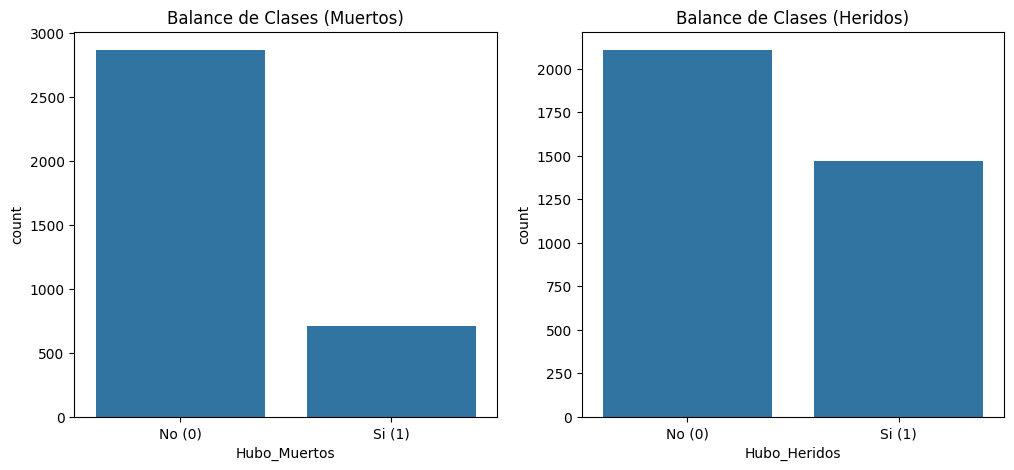

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Revisar balance de 'Hubo_Muertos'
print("--- Balance de 'Hubo_Muertos' ---")
print(Datos_codificados['Hubo_Muertos'].value_counts(normalize=True))

# 2. Revisar balance de 'Hubo_Heridos'
print("\n--- Balance de 'Hubo_Heridos' ---")
print(Datos_codificados['Hubo_Heridos'].value_counts(normalize=True))

# 3. Visualización
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='Hubo_Muertos', data=Datos_codificados, ax=ax[0])
ax[0].set_title('Balance de Clases (Muertos)')
ax[0].set_xticklabels(['No (0)', 'Si (1)'])

sns.countplot(x='Hubo_Heridos', data=Datos_codificados, ax=ax[1])
ax[1].set_title('Balance de Clases (Heridos)')
ax[1].set_xticklabels(['No (0)', 'Si (1)'])

plt.savefig("class_balance.png")

Observando las gráficas es evidente porqué obtenemos un resultado tan aparentemente "satisfactorio" en la predicción de los muertos comparado con el resultado en el número de heridos.

Nuestras sospechas se confirman y es que el modelo no está prediciendo prácticamente nada, el recall para SÍ HUBO MUERTOS es del 0.26, es decir, solo está encontrando 1/4 de los tiroteos donde SÍ HUBO MUERTOS.

La precisión del 80% es una ilusión. El modelo está "haciendo trampa" al predecir casi siempre "No" (la clase mayoritaria), y como el 80% de los datos son "No", acierta el 80% de las veces.

Para el caso de si hubo heridos el recall es un poco mejor pero teniendo en cuenta la precisión del modelo, en general los resultados son deficientes.

El Random Forest es un modelo de "caja blanca". Podemos preguntarle qué aprendió.

Vamos a ver cuáles de las 13 categorías (State, School_Level, Bullied, etc.) consideró más importantes para tomar sus decisiones.

--- Importancia de Features (Modelo 'Muertos') ---
               Feature  Importancia
0                State     0.287222
11         Shots_Fired     0.166501
1         School_Level     0.095023
4              Targets     0.080811
5           Accomplice     0.058201
8         Gang_Related     0.055381
12  Security_Screening     0.045625
9   Active_Shooter_FBI     0.044328
2       During_Classes     0.040657
6              Bullied     0.037060
7    Domestic_Violence     0.031220
3              GV_Type     0.029035
10          Preplanned     0.028938


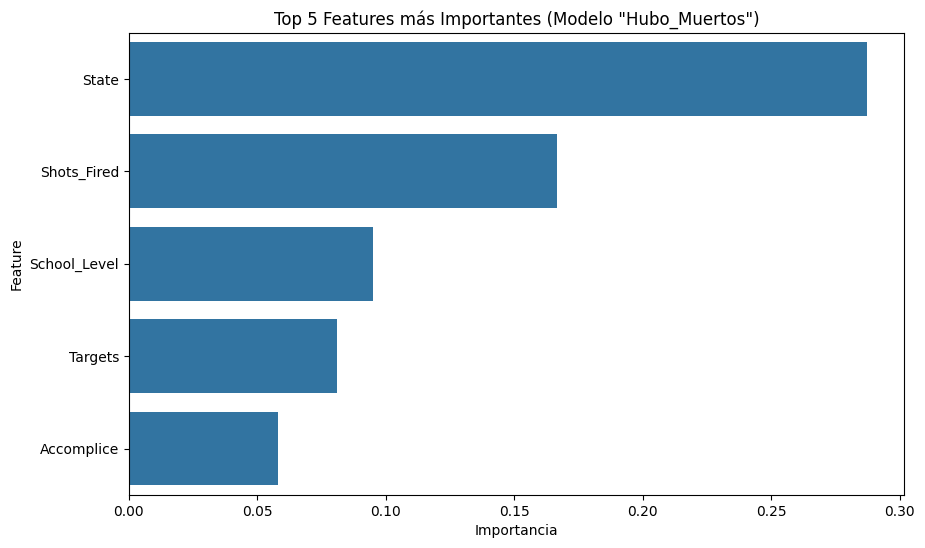

In [44]:
# Obtener las importancias
importancias = modelo_rf.feature_importances_
feature_names = X.columns

# Crear un DataFrame para verlo fácil
importancia_df = pd.DataFrame({
    'Feature': feature_names,
    'Importancia': importancias
})

# Ordenar de mayor a menor
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

print("--- Importancia de Features (Modelo 'Muertos') ---")
print(importancia_df)

# Graficar las 5 más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=importancia_df.head(5))
plt.title('Top 5 Features más Importantes (Modelo "Hubo_Muertos")')
plt.savefig("feature_importance.png")

Fijándonos en estos datos parece sospechoso que se le de tanta importancia al estado. Esto probablemente se deba a la alta cardinaldad de esa categoría. Estamos cayendo en un problema de overfitting que confunde al modelo, dejando de lado otras categorías intuitivamente más importantes como la planificación del delito.

En la siguiente celda haremos lo siguiente, re-entrenaremos al modelo corrigiendo el desbalance. Es posible que sacrifiquemos precisión pero deberíamos de mejorar el recall.

In [46]:
# (Asumiendo que X_train, X_test, y_train, y_test para 'Muertos' ya existen)

# 1. Inicializar el modelo CON class_weight
# Esto le dice al modelo que pese las clases inversamente a su frecuencia
modelo_rf_balanceado = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # <-- LA MAGIA ESTÁ AQUÍ
)

# 2. Entrenar
print("Entrenando modelo balanceado para 'Hubo_Muertos'...")
modelo_rf_balanceado.fit(X_train, y_train)
print("Entrenamiento completado.")

# 3. Evaluar
y_pred_bal = modelo_rf_balanceado.predict(X_test)
accuracy_bal = accuracy_score(y_test, y_pred_bal)

print(f"\nPrecisión (Accuracy) BALANCEADA: {accuracy_bal * 100:.2f}%")
print("-" * 50)
print("Reporte de Clasificación (BALANCEADO):")
print(classification_report(y_test, y_pred_bal, target_names=['No (0)', 'Si (1)']))

Entrenando modelo balanceado para 'Hubo_Muertos'...
Entrenamiento completado.

Precisión (Accuracy) BALANCEADA: 79.86%
--------------------------------------------------
Reporte de Clasificación (BALANCEADO):
              precision    recall  f1-score   support

      No (0)       0.85      0.92      0.88       587
      Si (1)       0.40      0.24      0.30       128

    accuracy                           0.80       715
   macro avg       0.62      0.58      0.59       715
weighted avg       0.77      0.80      0.78       715



El resultado obtenido es extremandamente interesante y es que es muy raro que el recall empeore tras haber balanceado. Ahora que sabemos que State está envenenando el modelo, y class_weight por sí solo no funciona, vamos a combinar las dos soluciones.

Entrenando modelo (Balanceado Y Sin State)...
Entrenamiento completado.

Precisión (Combo): 78.60%
Reporte de Clasificación (Combo: Balanceado + Sin State):
              precision    recall  f1-score   support

      No (0)       0.87      0.87      0.87       587
      Si (1)       0.41      0.42      0.41       128

    accuracy                           0.79       715
   macro avg       0.64      0.64      0.64       715
weighted avg       0.79      0.79      0.79       715

--------------------------------------------------

--- NUEVA Importancia de Features (Sin State) ---
               Feature  Importancia
10         Shots_Fired     0.227740
0         School_Level     0.157250
3              Targets     0.137711
4           Accomplice     0.076690
7         Gang_Related     0.070545
11  Security_Screening     0.065103
8   Active_Shooter_FBI     0.058918
1       During_Classes     0.054216
5              Bullied     0.042512
2              GV_Type     0.039649
9           Prepla

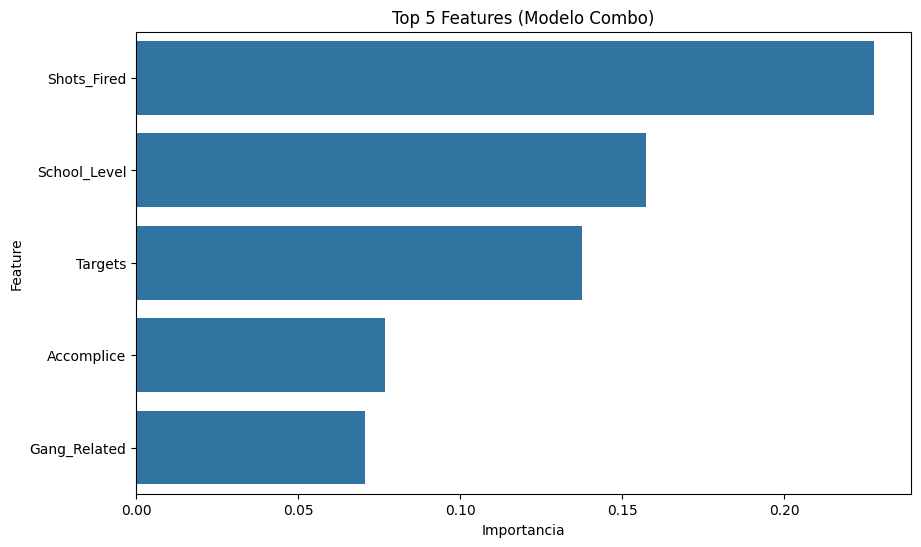

In [47]:
# 1. Crear copias de nuestros sets de datos SIN 'State'
X_train_sin_state = X_train.drop('State', axis=1)
X_test_sin_state = X_test.drop('State', axis=1)

# 2. Inicializar el modelo con AMBAS soluciones:
# class_weight='balanced' Y usando los datos sin 'State'
modelo_rf_combo = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced' # <-- Solución 1 (para el 80/20)
)

# 3. Entrenar con los datos SIN 'State' (Solución 2)
print("Entrenando modelo (Balanceado Y Sin State)...")
# Nota: usamos y_train (el original), no ha cambiado
modelo_rf_combo.fit(X_train_sin_state, y_train)
print("Entrenamiento completado.")

# 4. Evaluar
y_pred_combo = modelo_rf_combo.predict(X_test_sin_state)
accuracy_combo = accuracy_score(y_test, y_pred_combo) # y_test es el mismo

print(f"\nPrecisión (Combo): {accuracy_combo * 100:.2f}%")
print("Reporte de Clasificación (Combo: Balanceado + Sin State):")
print(classification_report(y_test, y_pred_combo, target_names=['No (0)', 'Si (1)']))
print("-" * 50)

# 5. REVISAR FEATURE IMPORTANCE
# (Este es el momento de la verdad)

importancias_combo = modelo_rf_combo.feature_importances_
feature_names_combo = X_train_sin_state.columns # Nombres de features sin 'State'

importancia_df_combo = pd.DataFrame({
    'Feature': feature_names_combo,
    'Importancia': importancias_combo
})
importancia_df_combo = importancia_df_combo.sort_values(by='Importancia', ascending=False)

print("\n--- NUEVA Importancia de Features (Sin State) ---")
print(importancia_df_combo)

# Graficar las 5 más importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Feature', data=importancia_df_combo.head(5))
plt.title('Top 5 Features (Modelo Combo)')
plt.savefig("feature_importance_combo.png")

Vemos como hemos podido mejorar notablemente el modelo aplicando estas dos soluciones. Aún así los resultados son muy mejorables. Es posible que el modelo se siga dejando llevar por categorías con alta cardinalidad, por lo que en vez de sacrificar más datos probablemente sea más adecuado pasar directamente a usar una red neuronal para ver si podemos mejorar nuestra capacidad predictiva.